# Intuitional Description

Bayesian model comparison evaluates competing models by measuring how well they predict observed data while accounting for model complexity, which is reflected in how broadly the prior distribution spreads probability across the parameter space.

# Graphical Summary

![fig](./cartoons/Bayesian_model_comparison.svg)

# Key Formula

When comparing two models $M_1$ and $M_2$, we calculate the **posterior odds** for each model. The **posterior odds** represent the ratio of the posterior probabilities for the two models. This can be written as:

$$
\frac{P(M_1|D)}{P(M_2|D)} = \frac{P(D|M_1)P(M_1)}{P(D|M_2)P(M_2)}
$$

Where:
- $P(M_1|D)$ is the **posterior** probability of model $M_1$ given the data $D$.
- $P(M_2|D)$ is the **posterior** probability of model $M_2$ given the data $D$.
- $\frac{P(D|M_1)}{P(D|M_2)}$ is the **bayes factor** of $M_1$ and $M_2$
- $P(M_1)$ and $P(M_2)$ are the **prior probabilities** of models $M_1$ and $M_2$, respectively.


# Technical Details


Recall that the **Bayes Factor (BF)** is defined as:

$$
\text{BF}_{1,2} = \frac{L(\text{D}|\text{M}_1)}{L(\text{D}|\text{M}_2)} ={\frac {\int \Pr(\gamma _{1}|M_{1})\Pr(D|\gamma _{1},M_{1})\,d\gamma _{1}}{\int \Pr(\gamma _{2}|M_{2})\Pr(D|\gamma _{2},M_{2})\,d\gamma _{2}}} = \frac{\frac{Pr(M_1|D)Pr(D)}{Pr(M_1)} }{\frac{Pr(M_2|D)Pr(D)}{Pr(M_2)}} = \frac{Pr(M_1|D)}{Pr(M_2|D)} \times \frac{Pr(M_2)}{Pr(M_1)}
$$


This ratio here, $\frac{P(M_1|D)}{P(M_2|D)}$, simplifies to:

$$
\text{Posterior Odds} = \text{Prior Odds} \times \text{Bayes Factor (BF)}
$$

Where:
- **Prior Odds** = $\frac{P(M_1)}{P(M_2)}$ is the ratio of prior probabilities of the models.
- **Bayes Factor (BF)** = $\frac{P(D|M_1)}{P(D|M_2)}$ is the Bayes Factor of the two models given data $\text{D}$.

Thus, the **posterior odds** can be updated by multiplying the **prior odds** by the **Bayes Factor**.

# Example

## Example 1 -- fine mapping

This example demonstrates Bayesian fine mapping in genetics, which is used to identify causal genetic variants associated with a trait or disease. The code simulates a scenario with three correlated SNPs (Single Nucleotide Polymorphisms) where at least one has a strong signal (Z-score of 5.1).

The analysis:
1. compares seven possible causal configurations (from zero to two causal SNPs) by calculating approximate Bayes factors for each model
2. combines these with prior probabilities to compute posterior probabilities
3. calculates the Posterior Inclusion Probability (PIP) for each SNP, which represents the probability that each SNP is causal, and visualizes these results.

We'll first simulate a scenario with 3 SNPs that have Z-scores (association statistics) and are in linkage disequilibrium (LD):

In [5]:
rm(list = ls()) # Clear the workspace
# Load necessary libraries
library(MASS)      # for multivariate normal
library(ggplot2)   # for plots
library(tibble)    # for tidy tables
library(dplyr)     # for data manipulation

In [6]:
# Simulate Z-scores for 3 SNPs
Z <- c(5.1, 2.0, 1.8)
names(Z) <- c("SNP_A", "SNP_B", "SNP_C")

# Simulate LD matrix
R <- matrix(c(
  1.0, 0.8, 0.6,
  0.8, 1.0, 0.7,
  0.6, 0.7, 1.0
), nrow = 3, byrow = TRUE)
colnames(R) <- rownames(R) <- names(Z)
Z
R

SNP_A SNP_B SNP_C 
  5.1   2.0   1.8

,SNP_A,SNP_B,SNP_C
SNP_A,1.0,0.8,0.6
SNP_B,0.8,1.0,0.7
SNP_C,0.6,0.7,1.0


We're considering 7 possible models: 
- null model (no causal SNPs)
- 3 single-SNP models
- 3 two-SNP models
This represents all possible combinations of up to 2 causal SNPs.

In [7]:
# Possible causal configurations (max 2 causal SNPs)
configs <- list(
  c(),                 # M0: null
  c(1), c(2), c(3),    # Single SNP
  c(1, 2), c(1, 3), c(2, 3)  # Pairs
)


Now we'll calculate the Approximate Bayes Factor (ABF) for each configuration:

We assume:
- Effect sizes $\sim N(0, \sigma^2)$
- $Z \sim N(R\beta, R)$

ABF Explanation:

- The ABF measures how well each model explains the observed Z-scores
- Higher ABF indicates stronger evidence for that model
- The sigma2 parameter (0.05) represents our prior belief about effect sizes

The ABF calculation accounts for:

- The strength of association (Z-scores)
- The correlation structure between SNPs (LD matrix)
- The complexity of the model (number of causal SNPs)

In [8]:
compute_abf <- function(causal_idx, Z, R, sigma2 = 0.05) {
  if (length(causal_idx) == 0) {
    return(1)  # model with no causal SNPs
  }
  # Subset R and Z
  R_c <- R[causal_idx, causal_idx, drop = FALSE]
  Z_c <- Z[causal_idx]
  V <- R_c + sigma2 * diag(length(causal_idx))
  exponent <- t(Z_c) %*% solve(V) %*% Z_c
  abf <- sqrt(det(R_c) / det(V)) * exp(0.5 * exponent)
  return(abf)
}

abfs <- sapply(configs, compute_abf, Z = Z, R = R)


We combine the ABFs with prior probabilities to compute posterior probabilities:

In [9]:
# Set prior p(causal SNP) = 0.01
p <- 0.01
m <- length(Z)

# Prior on each model
model_priors <- sapply(configs, function(cfg) {
  k <- length(cfg)
  p^k * (1 - p)^(m - k)
})

In [10]:
# Posterior probabilities
unnorm_posteriors <- abfs * model_priors
posteriors <- unnorm_posteriors / sum(unnorm_posteriors)
posteriors

[1] 2.750877e-04 6.490657e-01 1.821666e-05 1.268515e-05 3.356221e-01
[6] 1.500606e-02 2.073618e-07

Finally, we calculate the Posterior Inclusion Probability (PIP) for each SNP:

In [11]:
# PIP for each SNP
pip <- setNames(rep(0, m), names(Z))
for (i in seq_along(configs)) {
  cfg <- configs[[i]]
  if (length(cfg) > 0) {
    pip[cfg] <- pip[cfg] + posteriors[i]
  }
}


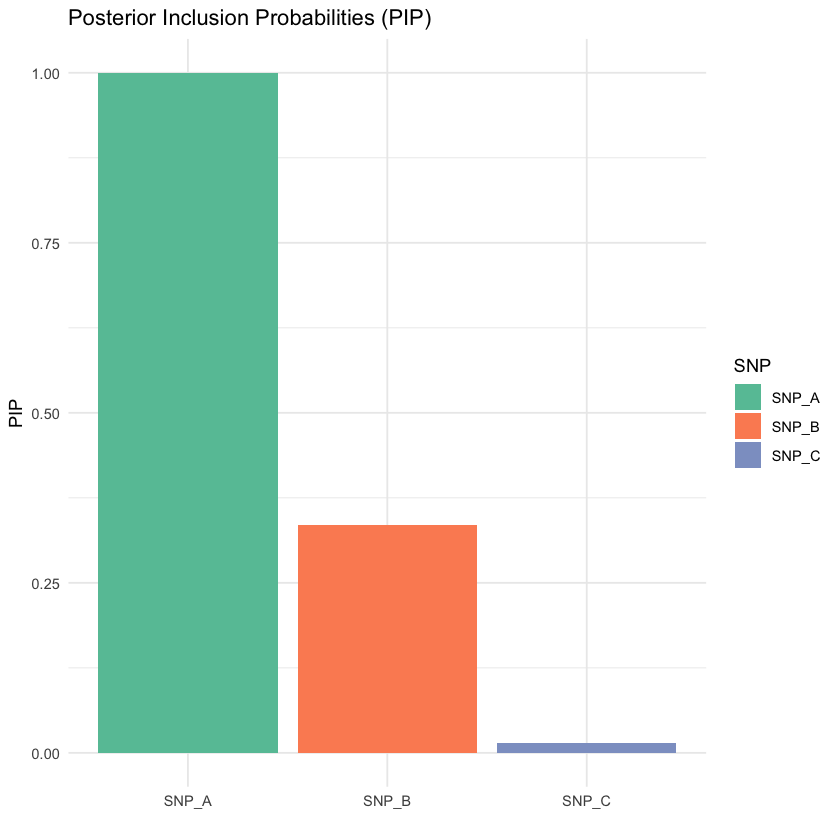

In [12]:
pip_df <- tibble(
  SNP = names(pip),
  PIP = pip
)

ggplot(pip_df, aes(x = SNP, y = PIP, fill = SNP)) +
  geom_bar(stat = "identity") +
  ylim(0, 1) +
  labs(title = "Posterior Inclusion Probabilities (PIP)",
       y = "PIP", x = "") +
  theme_minimal() +
  scale_fill_brewer(palette = "Set2")


## Example 2 -- multivariate regression

This document demonstrates Bayesian model comparison for multivariate regression in the context of genetics. We'll analyze genetic variants (SNPs) that may affect multiple traits simultaneously, determining which model best explains the observed associations.

The key aspects we'll explore:

1. Modeling correlations between genetic variants (LD structure)
2. Handling multiple traits simultaneously
3. Evaluating different causal models using Bayes Factors
4. Calculating posterior probabilities for model comparison

We start by defining the correlation structure between 3 SNPs:

In [13]:
rm(list = ls())  # Clear workspace
library(MASS)     # For multivariate normal distribution
library(tibble)   # For tidy data

# --- 1. Define LD matrix for 3 SNPs ---
R <- matrix(c(
  1.0, 0.8, 0.2,
  0.8, 1.0, 0.7,
  0.2, 0.7, 1.0
), nrow = 3, byrow = TRUE)
colnames(R) <- rownames(R) <- c("SNP_A", "SNP_B", "SNP_C")


We'll simulate Z-scores for 2 traits across our 3 SNPs:

In [14]:
# --- 2. Simulate Z-scores for 2 traits ---
Z_trait1 <- c(5.0, 2.5, 1.5)  # Signal in SNP_A, others due to LD
Z_trait2 <- c(0.5, 0.2, -0.1) # No signal

Z <- rbind(Z_trait1, Z_trait2)
colnames(Z) <- c("SNP_A", "SNP_B", "SNP_C")
rownames(Z) <- c("Trait1", "Trait2")
print(Z)


       SNP_A SNP_B SNP_C
Trait1   5.0   2.5   1.5
Trait2   0.5   0.2  -0.1


We'll define 4 possible models for how SNP_A might affect the two traits:

In [15]:
# --- 3. Define models ---
models <- list(
  M0 = c(FALSE, FALSE),  # No effect
  M1 = c(TRUE, FALSE),   # Effect on Trait1 only
  M2 = c(FALSE, TRUE),   # Effect on Trait2 only
  M3 = c(TRUE, TRUE)     # Effect on both traits
)


We need a function to calculate how well each model explains the observed Z-scores:

Explanation:

- The following function calculates the log-likelihood under a multivariate normal distribution:
- `z_vec` contains the observed Z-scores for SNP_A across both traits
- `mu_vec` contains the expected effect sizes under a given model
- `Sigma` is the covariance matrix (here we use an identity matrix, assuming independence between traits)
- Higher log-likelihood indicates better fit to the observed data

In [17]:
# --- 4. Define log-likelihood function ---
log_likelihood <- function(z_vec, mu_vec, Sigma) {
  dist <- z_vec - mu_vec
  ll <- -0.5 * t(dist) %*% solve(Sigma) %*% dist  # Multivariate normal log-likelihood
  return(as.numeric(ll))
}


We'll calculate the log marginal likelihood for each model:

In [18]:
# --- 5. Compute log-likelihoods for each model ---
log_marg_liks <- sapply(models, function(effect_mask) {
  mu <- rep(0, 2)  # Initial effect sizes (set to zero)
  # Use a normal prior for the effect sizes, not hardcoded to 5
  mu[effect_mask] <- rnorm(sum(effect_mask), mean = 0, sd = 1)  # Sampling effect size from normal prior
  log_likelihood(Z[, "SNP_A"], mu, diag(2))  # Use diagonal covariance (independence across traits)
})

Explanation:

- For each model, we calculate how well it explains the Z-scores for SNP_A across both traits
- We use a normal prior with mean 0 and SD 1 for the effect sizes
- We assume independence between traits (diagonal covariance matrix)
- The log-likelihoods give us a measure of model fit, but we need to convert them to Bayes Factors for proper comparison

Now we'll calculate Bayes Factors and posterior probabilities:

In [19]:
# --- 6. Calculate Bayes Factors and Posterior ---
log_BFs <- log_marg_liks - log_marg_liks["M0"]  # Compare to null model
BFs <- exp(log_BFs)
posterior <- BFs / sum(BFs)  # Normalize to get posterior probabilities

Explanation:

- Bayes Factors (BFs) quantify the evidence for each model compared to the null model (M0)
- BF > 1 indicates evidence in favor of the model over the null
- BF < 1 indicates evidence against the model compared to the null
- Posterior probabilities give us the probability of each model being correct, given the data
- The model with the highest posterior probability is our best model

In [20]:
# --- 7. Output results ---
results <- tibble(
  Model = names(models),
  logLik = round(log_marg_liks, 2),
  BF = round(BFs, 2),
  PostProb = round(posterior, 3)
)

print(results)


# A tibble: 4 x 4
  Model logLik    BF PostProb
  <chr>  <dbl> <dbl>    <dbl>
1 M0     -12.6  1       0.068
2 M1     -10.1 12.8     0.87 
3 M2     -12.7  0.91    0.062
4 M3     -21.1  0       0    


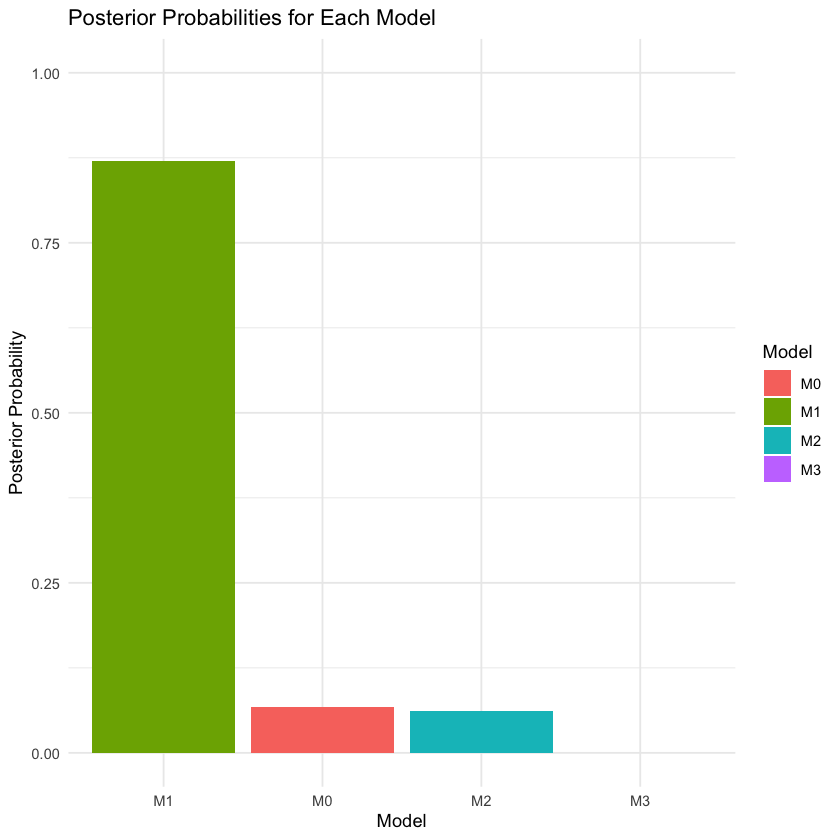

In [21]:
# Visualize posterior probabilities
ggplot(results, aes(x = reorder(Model, -PostProb), y = PostProb, fill = Model)) +
  geom_bar(stat = "identity") +
  labs(title = "Posterior Probabilities for Each Model",
       x = "Model", y = "Posterior Probability") +
  theme_minimal() +
  ylim(0, 1)